In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data = data.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1)

In [6]:
data['Sex'] = data['Sex'].map({'male':0, 'female':1})
data['Embarked'] = data['Embarked'].fillna(value='C')
data['Embarked'] = data['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [7]:
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data = data.drop(columns='Name')
data['Title'] = data['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 'Others')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Others':4})

In [ ]:
NaN_indexes = data['Age'][data['Age'].isnull()].index
for i in NaN_indexes:
    pred_age = data['Age'][((data.SibSp == data.iloc[i]["SibSp"]) & (data.Parch == data.iloc[i]["Parch"]) & (data.Pclass == data.iloc[i]["Pclass"]))].median()
    if not np.isnan(pred_age):
        data['Age'].iloc[i] = pred_age
    else:
        data['Age'].iloc[i] = data['Age'].median()

In [10]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [11]:
data['Age'] = data['Age'] / 100
data['Fare'] = data['Fare'] / 100

In [12]:
import torch

feature_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize']
X = torch.from_numpy(data[feature_columns].values).float()
y = torch.from_numpy(data['Survived'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [13]:
from decision_tree import DecisionTreeClassifier, DecisionTreeRegressor
from linear_model import LogisticRegression, RidgeRegression
from svm import DualSoftSVC, LinearSVC
from ensemble import RandomForest, GradientBoostingRegressor
from knn import KNN

In [14]:
input_dim = 9
clf_list = [
    (LogisticRegression(input_dim), 'LR'),
    (DualSoftSVC(len(X_train), C=1.0, gamma=50, iters=10000, lr=1e-5), 'SVC'),
    (DecisionTreeClassifier(input_dim, num_class=2, max_depth=10), 'DT'),
    (RandomForest(input_dim, num_class=2, n_estimators=20, max_depth=10), 'RF'),
    (GradientBoostingRegressor(input_dim, lr=0.01, n_estimators=20, max_depth=10), 'GBDT'),
    (KNN(K=5), 'KNN')
]

In [15]:
names = []
roc_curves = []
auc = []

for clf, name in clf_list:
    if name in ['LR', 'GBDT', 'KNN']:
        clf.fit(X_train.clone(), y_train.clone().float())
    elif name == 'SVC':
        label = y_train.clone().float() * 2 - 1
        clf.fit(X_train.clone(), label)
    else:
        clf.fit(X_train.clone(), y_train.clone())
    pred = clf.predict(X_test.clone())
    if name == 'SVC':
        pred = torch.sigmoid(pred)

    if pred.dim() == 2:
        pred = pred[:, 1]
    
    auc.append(roc_auc_score(y_test, pred))
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_curves.append([fpr, tpr])
    names.append(name)

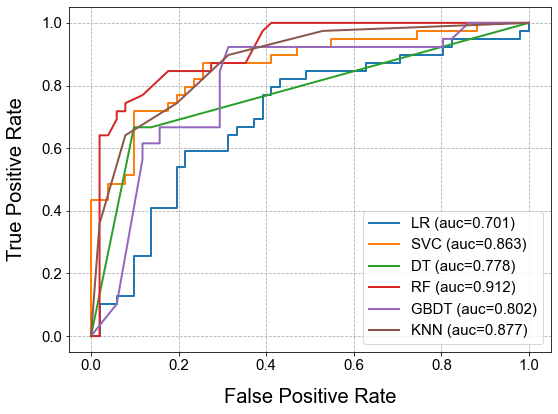

In [16]:
plt.figure(figsize=(8, 6))
for name, a, (fpr, tpr) in zip(names, auc, roc_curves):
    plt.plot(fpr, tpr, label='%s (auc=%.3f)' % (name, a), linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(linestyle='--')
plt.legend()
plt.tight_layout()